# Проект для классификации текста с использованием модели BERT

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные с помощью набора данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Ход проекта**

1. Загрузка и подготовка данных
2. Обучите разных моделей
3. Общий вывод выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем библиотеки, объявляем константы, проверяем работоспособность cuda

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install --upgrade lightgbm -q

In [3]:
!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128 -q

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 -q

In [5]:
!pip install --upgrade transformers -q

In [6]:
import re 
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer 

import lightgbm as lgb

from tqdm import notebook

import torch

from transformers import AutoModel, AutoTokenizer

In [7]:
warnings.filterwarnings('ignore')

In [8]:
RANDOM_STATE = 42

In [9]:
print(torch.cuda.is_available())

True


Загрузим данные, выведем информацию и первые строки

In [10]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('datasets/toxic_comments.csv')

In [11]:
display(data.head(5))
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


* Столбец "Unnamed: 0" копирует индексы, удалим его
* Типы данных записаны корректно
* Пропуски отсутствуют
* Всего имеется 159292 записи

In [12]:
data = data.drop(columns='Unnamed: 0')
data.columns

Index(['text', 'toxic'], dtype='object')

Проверим наличие явных дубликатов, удалим при необходимости

In [13]:
data['text'].duplicated().sum()

0

Рассмотрим распределение целевого признака

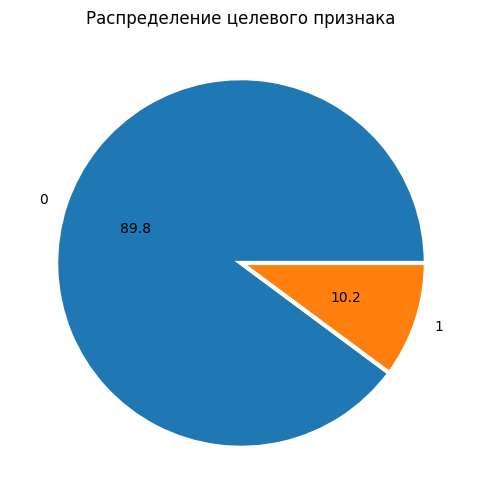

In [14]:
plt.figure(figsize=(6, 6))
plt.pie(
        data['toxic'].value_counts(), 
        labels=data['toxic'].value_counts().index,     
        autopct='%.1f',  
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
        labeldistance = 1.1
)
plt.title('Распределение целевого признака')
plt.legend=True
plt.show()

Присутствует сильный дисбаланс: токсичных комментариев всего 10% из общего числа. Чтобы учесть это, при разбиении данных на подвыборки будем использовать стратификацию для сохранения пропорции, а при обучении моделей будем подбирать веса для признаков чтобы лучше определять малочисленный класс.

Далее рассмотрим примеры токсичных комментариев чтобы решить как обрабатывать текст и на что обращать внимание

In [15]:
display(data.query('toxic == 1').sample(10))

,text,toxic
61758,"Please keep your whining off my talk page, KTH...",1
79993,Vandalism Accusation\nMy edit to Montel Vontav...,1
59408,So you are another vile little Englishman like...,1
107348,"""\n\n Blocking Mardyks \n\nExcellent work ther...",1
66475,"""Vandalism==\nI'm damn sick and tired of idiot...",1
157532,How big is your pee pee.,1
95912,=when=\nWhen the fuck im i unblocked you dick ...,1
147401,Have theguts \n\nHave the guts and improve the...,1
148330,"This article is already bad enough, dont make ...",1
42784,Malta is an Arab! \n\nStop lying!,1


В основном в эту категорию попадают комментарии с оскорблениями и нецензурными словами. В первую очеред стоит искать именно их. Причем слова часто написаны с ошибками, а значит лемматизация сработает плохо. Чтобы очистить текст от ненужных символов оставим только латинские буквы и символ ', а получившиеся слова разделим пробелами и оставим как есть.

In [16]:
def clear_text(text):
    t = re.sub(r"[^a-zA-Z']", ' ', text) 
    return ' '.join(t.split())

In [17]:
for i in list(data.index):
    data.at[i, 'text'] = clear_text(data['text'][i])

## Обучение

### Обучение с помощью Tf-Idf

Разделим данные на обучающую и тестовую выборку с исползованием стратификации.

Векторизируем фразы с использованием 4-граммов внутри слов, чтобы выделить основную часть бранных слов, даже если они были сложносоставные или написаны с ошибками. Также уберем 4-граммы, встречающиеся больше чем в 10% строк, поскольку они точно не принадлежат только к токсичным фразам. Также уберем очень редко встречающиеся части слов чтоб не создавать шум в данных.

In [18]:
X = data['text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=data['toxic']
)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119469,)

(39823,)

(119469,)

(39823,)

In [19]:
corpus_train = X_train.values.astype('U')
corpus_test = X_test.values.astype('U')

In [20]:
tf_idf = TfidfVectorizer(analyzer = 'char_wb', 
                         strip_accents = 'ascii',
                         ngram_range=(4, 4), 
                         max_df=0.1, 
                         min_df=50
                        ) 

In [21]:
tf_idf_train = tf_idf.fit_transform(corpus_train)
tf_idf_test = tf_idf.transform(corpus_test)
tf_idf_train

<119469x14493 sparse matrix of type '<class 'numpy.float64'>'
	with 12987454 stored elements in Compressed Sparse Row format>

Подберем гиперпараметры для моделей логистической регрессии и LightGBM, в том числе веса классов

In [22]:
def rs (estimator, params, X, y, niter=20):
    rand_search = RandomizedSearchCV(
        estimator, 
        params, 
        scoring='f1',
        n_jobs=-1, 
        n_iter=niter, 
        random_state=RANDOM_STATE, 
        cv=3
    )
    rand_search.fit(X, y)
    print('Лучшая модель и её параметры:', rand_search.best_estimator_)
    print (
        'Метрика лучшей модели на кросс-валидации:', 
        rand_search.best_score_.round(3)
    )
    return rand_search

In [23]:
class_weights = ({0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:2.5})

In [24]:
logreg = LogisticRegression(random_state=RANDOM_STATE)

In [25]:
parameters_logreg = {'C': np.arange(0.1, 8, 0.05), 
             'class_weight': class_weights
             }

In [26]:
logreg_tfidf = rs(logreg, parameters_logreg, tf_idf_train, y_train)

Лучшая модель и её параметры: LogisticRegression(C=5.200000000000001, class_weight={0: 1, 1: 2},
                   random_state=42)
Метрика лучшей модели на кросс-валидации: 0.794


In [27]:
lgbc = lgb.LGBMClassifier(
        random_state=RANDOM_STATE, 
        verbosity=-1, 
        learning_rate=0.3,
        extra_trees=True,
        n_jobs=-1,
        n_iter=120
    )

In [28]:
parameters_lgb = {'num_leaves': range(70, 100, 10), 
                  'class_weight': class_weights}

In [29]:
lgbc_tfidf = rs(lgbc, parameters_lgb, tf_idf_train, y_train, niter=5)

Лучшая модель и её параметры: LGBMClassifier(class_weight={0: 1, 1: 2.5}, extra_trees=True, learning_rate=0.3,
               n_iter=120, n_jobs=-1, num_leaves=80, random_state=42,
               verbosity=-1)
Метрика лучшей модели на кросс-валидации: 0.796


Бустинг показал себя лучше, для экономии памяти удалим логистическую регрессию

In [30]:
del logreg_tfidf

### Обучение с помощью BERT

Поскольку стоит задача поиска токсичных комментарие, будем использовать специализированную для этого предобученную модель 'unitary/toxic-bert'.

Поскольку доступна технология cuda, будем создавать эмбеддинги с использованием видеокарты для ускорения процесса.

Будем сиитать эмбеддинги для небольшой выборки для ускорения процесса. Чтобы не тратить слишком много ресурсов, будем делить данные на батчи по 80 строк. Переведем модель и тензоры на gpu, а эмбеддинги переместим обратно на cpu чтобы добавить в список

In [31]:
data_bert, data_other = train_test_split(
    data, 
    test_size=0.9, 
    random_state=RANDOM_STATE, 
    stratify=data['toxic']
)
display(data_bert.shape, data_other.shape)

(15929, 2)

(143363, 2)

In [32]:
del data_other

In [33]:
model_class, tokenizer_class, pretrained_weights = (AutoModel, AutoTokenizer, 'unitary/toxic-bert')

In [34]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [35]:
tokenized = data_bert['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512)))

In [36]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [37]:
attention_mask = np.where(padded != 0, 1, 0)

In [38]:
%%time
batch_size = 80 
embeddings = []
model.cuda()  
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.IntTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
        attention_mask_batch = torch.IntTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) 
        del batch
        del attention_mask_batch
        del batch_embeddings

features = np.concatenate(embeddings)

  0%|          | 0/199 [00:00<?, ?it/s]

CPU times: total: 18min 15s
Wall time: 18min 25s


Возьмем целевые признаки для всех получившихся эмбеддингов, разделим выборку и обучим модели

In [39]:
features.shape

(15920, 768)

In [40]:
target = data_bert['toxic'].head(features.shape[0])
target.shape

(15920,)

In [41]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    features, target, 
    test_size=0.5, 
    random_state=RANDOM_STATE, 
    stratify=target
)
display(X_train_bert.shape, X_test_bert.shape, y_train_bert.shape, y_test_bert.shape)

(7960, 768)

(7960, 768)

(7960,)

(7960,)

In [42]:
logreg_bert = rs(logreg, parameters_logreg, X_train_bert, y_train_bert)

Лучшая модель и её параметры: LogisticRegression(C=0.25000000000000006, class_weight={0: 1, 1: 1.5},
                   random_state=42)
Метрика лучшей модели на кросс-валидации: 0.918


Логистическая регрессия на эмбеддингах показала себя ещё лучше, можно удалить прошлую модель

In [43]:
del lgbc_tfidf

In [44]:
lgbc_bert = rs(lgbc, parameters_lgb, X_train_bert, y_train_bert, niter=5)

Лучшая модель и её параметры: LGBMClassifier(class_weight={0: 1, 1: 2}, extra_trees=True, learning_rate=0.3,
               n_iter=120, n_jobs=-1, num_leaves=90, random_state=42,
               verbosity=-1)
Метрика лучшей модели на кросс-валидации: 0.92


In [45]:
del logreg_bert

Лучше всего на кросс-валидации себя показала модель LightGBM на эмбеддингах, можно подобрать для неё порог. Для этого выделим из тренировочной выборки валидационную и с её помощью подберем порог для обученной на оставшейся тестовой выборке модели

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_bert, y_train_bert, 
    test_size=0.5, 
    random_state=RANDOM_STATE, 
    stratify=y_train_bert
)
display(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3980, 768)

(3980, 768)

(3980,)

(3980,)

In [47]:
lgbc_bert.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(extra_trees=True, learning_rate=0.3,
                                            n_iter=120, n_jobs=-1,
                                            random_state=42, verbosity=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'class_weight': ({0: 1, 1: 1.5},
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 2.5}),
                                        'num_leaves': range(70, 100, 10)},
                   random_state=42, scoring='f1')

In [48]:
max_score = 0
value = 0
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 50,endpoint=False)]
for i in thresholds:
    y_pred = lgbc_bert.predict_proba(X_val)[:,1] >= i
    score = f1_score(y_val, y_pred)
    if score>max_score:
        value=i
        max_score=score
        max_y_pred=y_pred
display(f"f1 = {max_score:.3f}")
display(f"Порог = {value}")

'f1 = 0.923'

'Порог = 0.55'

Лучшая метрика достигается при пороге классификации в 0,55. Можно снова обучить модель на всех тренировочных данных и проверить на тестовой выборке с применением порога

In [49]:
lgbc_bert.fit(X_train_bert, y_train_bert)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(extra_trees=True, learning_rate=0.3,
                                            n_iter=120, n_jobs=-1,
                                            random_state=42, verbosity=-1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'class_weight': ({0: 1, 1: 1.5},
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 2.5}),
                                        'num_leaves': range(70, 100, 10)},
                   random_state=42, scoring='f1')

### Тестирование модели

f1 = 0.919


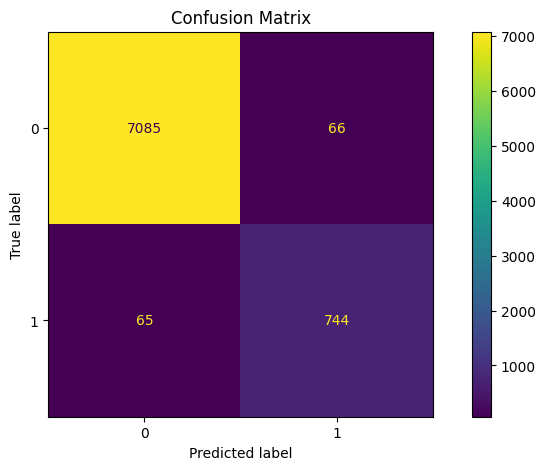

In [50]:
y_pred = lgbc_bert.predict_proba(X_test_bert)[:,1] >= value
print(f"f1 = {f1_score(y_test_bert, y_pred):.3f}")
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test_bert, y_pred, ax=ax)
_ = ax.set_title(
    f"Confusion Matrix"
)

На тестовых данных модель с порогом показала f1 меру, равную 0,919, что выше заданного условия в 0,75

## Выводы

**Предобработка и анализ данных**
* Для обучения моделей предсказания токсичности текста были получены промаркированные комментарии, всего 159292 записи.
* В результате предобработки был удален столбец с индексами, а текст очищен от ненужных символов.
* При анализе данных был выявлен сильный дисбаланс целевого признака: токсичные комментарии составляют всего 10% от общего числа.

**Обучение и тестирование моделей**
* Для обучения моделей были использованы два способа преобразования слов в понятный для модели векторный вид. Первый это подсчитывающий уникальные слова Tf-Idf, а другой это оценивающий смысловую близость слов эмбеддинг, реализованный в предобученной модели BERT.
* Для предсказания токсичности текста в обоих случаях были подобраны гиперпараметры и веса классов для модели логистической регрессии и градиентного бустинга LightGBM
* Лучше всего себя показала модель градиентного бустинга, обучавшаяся на эмбеддингах, с порогом классификации равным 0,55.
* Итоговая метрика f1 на тестовых данных составила 0,919, что с запасом соответствует требованию.
* Модель допускает примерно одинаковое количество ложноположительных и ложноотрицательных ответов, что связано с настройкой на лучшую f1 меру. Для лучшего определения конкретного класса следует провести настройку исходя из других метрик.